# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import optuna

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 파일 경로 설정
file_path = '../data/'

# 파일 불러오기
df = pd.read_csv(file_path + 'final.csv') # 깃헙용 명칭
sample_submission = pd.read_csv(file_path + 'sample_submission.csv')

# 짧은 FE

In [7]:
# 202406 interest_rate 202405로 채우기
df[df["contract_year_month"] == 202405]["interest_rate"].unique()
df["interest_rate"].fillna(3.56, inplace=True)

array([3.56])

In [18]:
# 파일 불러오기
interest_rate_df = pd.read_csv(file_path + 'interestRate.csv')

interest_rate_df["contract_year_month"] = interest_rate_df["year_month"]
interest_rate_df.drop("year_month", axis=1, inplace=True)

interest_rate_df.loc[len(interest_rate_df)] = [3.56, 202406]

In [ ]:
# FE : interest_rate 기울기

# index 기준으로 역순 정렬
interest_rate_df = interest_rate_df.sort_index(ascending=False).reset_index(drop=True)

# 기울기를 계산할 함수 정의
def calculate_slope(series):
    if len(series) < 3:
        return np.nan  # 데이터가 3개월 미만일 때는 NaN 처리
    x = np.array(range(len(series)))
    y = np.array(series)
    slope = np.polyfit(x, y, 1)[0]  # 기울기 계산
    return slope

# 3개월치의 기울기를 계산해서 새로운 열로 추가
interest_rate_df['3_month_slope'] = interest_rate_df['interest_rate'].rolling(window=3).apply(calculate_slope, raw=True)

# 첫 번째 NaN 값 대체
first_valid_slope = interest_rate_df['3_month_slope'].dropna().iloc[0]
interest_rate_df['3_month_slope'].fillna(first_valid_slope, inplace=True)

# index 0은 0으로 대체
interest_rate_df.loc[0, '3_month_slope'] = 0

# index 1은 2개월치의 기울기로 계산
if len(interest_rate_df) > 1:
    x = np.array([0, 1])
    y = interest_rate_df.loc[0:1, 'interest_rate']
    two_month_slope = np.polyfit(x, y, 1)[0]
    interest_rate_df.loc[1, '3_month_slope'] = two_month_slope

# df와 interest_rate_df를 'contract_year_month'를 기준으로 병합
df = pd.merge(df, interest_rate_df[['contract_year_month', '3_month_slope']], 
              on='contract_year_month', 
              how='left')
df.head()

# 데이터 분할

In [29]:
columns = ['area_m2', 'floor',
       'built_year', 'latitude', 'longitude',
      #  'interest_rate',
       'previous_month_interest_rate', 'monthly_new_supply',
       'complex_id', 'max_deposit', 'cluster_labels',
      #  'deposit_per_area',
       'contract_year', 'contract_month',
       'mean_deposit_per_area_year',
       'max_deposit_per_area',
      #  'previous_deposit',
       'previous_deposit2',
    #    'half_year',
       'half_max_deposit',
       'deposit_std_id',
    #    'area_m2_category',
       'nearest_subway_distance_km', 'nearest_elementary_distance_km',
       'nearest_middle_distance_km', 'nearest_high_distance_km',
       'nearest_park_distance_km', 'nearest_park_area',
       'num_subway_within_0_5', 'num_subway_within_1', 'num_subway_within_2',
       'num_elementary_within_0_5', 'num_elementary_within_1',
       'num_elementary_within_2', 'num_middle_within_0_5',
       'num_middle_within_1', 'num_middle_within_2', 'num_high_within_0_5',
       'num_high_within_1', 'num_high_within_2', 'num_park_within_0_8',
       'num_park_within_1_5', 'num_park_within_2',
       'area_floor_interaction',
       'nearest_transportation_hub',
      #  'floor_area',
        'contract_type', 
       '3_month_slope']

In [33]:
# train, test split
train = df[df["_type"] == "train"].sort_values(by='index')
test = df[df["_type"] == "test"].sort_values(by='index')

holdout_start = 202307
holdout_end = 202312
holdout_data = train[(train['contract_year_month'] >= holdout_start) & (train['contract_year_month'] <= holdout_end)]
train_data = train[~(train['contract_year_month'] >= holdout_start) & (train['contract_year_month'] <= holdout_end)]

X_train_full = train_data[columns]
y_train_full = train_data['deposit']
X_holdout = holdout_data[columns]
y_holdout = holdout_data['deposit']
X_test = test[columns]

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 모델링

In [ ]:
import lightgbm as lgb
def objective(trial):
    params = {
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt']),
    # 'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2]),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
    'n_estimators': trial.suggest_int('n_estimators', 50, 500),
    'max_depth': trial.suggest_int('max_depth', 2, 16),
    'num_leaves': trial.suggest_int('num_leaves', 20, 100),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'objective': 'regression_l1',
    'random_state': RANDOM_SEED,
    'verbose': -1
    }
    model = lgb.LGBMRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mae',
        callbacks=[optuna.integration.LightGBMPruningCallback(trial, 'l1'), lgb.early_stopping(50, verbose=False)]
    )
    
    holdout_pred = model.predict(X_holdout)
    
    holdout_mae = mean_absolute_error(y_holdout, holdout_pred)
    holdout_rmse = root_mean_squared_error(y_holdout, holdout_pred)

    trial.set_user_attr("rmse", holdout_rmse)
    
    return holdout_mae
  

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [48]:
trial_lgb = study.best_trial
best_params_lgb = trial_lgb.params
best_mae_lgb = trial_lgb.value

print("Best trial:")
print(f"MAE: {trial_lgb.value}")
print(f"RMSE: {trial_lgb.user_attrs['rmse']}")
print("Best hyperparameters: ", trial_lgb.params)

Best trial:
MAE: 3442.0747401749013
RMSE: 5611.620429419843
Best hyperparameters:  {'loss_function': 'RMSE', 'iterations': 901, 'learning_rate': 0.05928029272464036, 'depth': 12, 'l2_leaf_reg': 3, 'eval_metric': 'MAE', 'random_seed': 42, 'logging_level': 'Silent', 'task_type': 'GPU'}


Best trial:   
MAE: 3433.937191036907   
RMSE: 5724.117930432466   
Best hyperparameters:  {'boosting_type': 'gbdt', 'learning_rate': 0.1686900811502798, 'n_estimators': 233, 'max_depth': 11, 'num_leaves': 84, 'subsample': 0.9116089240887149, 'colsample_bytree': 0.7268457056093285}

In [ ]:
import xgboost as xgb
def objective(trial):
    params = {
        'device': trial.suggest_categorical('device', ['cuda']),
        'objective': trial.suggest_categorical('objective', ['reg:absoluteerror']),
        'booster': trial.suggest_categorical('booster',['gbtree']),
        'tree_method': trial.suggest_categorical('tree_method',['hist']),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.01, 0.1, 0.2]),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 255),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'eval_metric': trial.suggest_categorical('eval_metric',['mae']),
        'random_state': trial.suggest_categorical('random_state', [RANDOM_SEED])
    }
    
    # DMatrix 객체로 변환
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dholdout = xgb.DMatrix(X_holdout, label=y_holdout)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=trial.suggest_int('num_boost_round', 50, 500),
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False,
        callbacks=[optuna.integration.XGBoostPruningCallback(trial, 'val-mae')],
    )
    
    holdout_pred = model.predict(dholdout)
    
    holdout_mae = mean_absolute_error(y_holdout, holdout_pred)
    holdout_rmse = root_mean_squared_error(y_holdout, holdout_pred)

    trial.set_user_attr("rmse", holdout_rmse)
    
    return holdout_mae


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [47]:
trial_xgb = study.best_trial
best_params_xgb = trial_xgb.params
best_mae_xgb = trial_xgb.value

print("Best trial:")
print(f"MAE: {trial_xgb.value}")
print(f"RMSE: {trial_xgb.user_attrs['rmse']}")
print("Best hyperparameters: ", trial_xgb.params)

Best trial:
MAE: 3442.0747401749013
RMSE: 5611.620429419843
Best hyperparameters:  {'loss_function': 'RMSE', 'iterations': 901, 'learning_rate': 0.05928029272464036, 'depth': 12, 'l2_leaf_reg': 3, 'eval_metric': 'MAE', 'random_seed': 42, 'logging_level': 'Silent', 'task_type': 'GPU'}


Best trial:   
MAE: 3431.573838729765   
RMSE: 5962.07447368747   
Best hyperparameters:  {'device': 'cuda', 'objective': 'reg:absoluteerror', 'booster': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.1, 'max_depth': 9, 'max_leaves': 255, 'subsample': 0.9339458777384791, 'colsample_bytree': 0.789333445231045, 'eval_metric': 'mae', 'random_state': 42, 'num_boost_round': 306}

In [54]:
# catboost용 카테고리 변수 생성 (FE)

data = df.copy()

# 변수 목록
variables = ['area_m2', 'floor', 'built_year', 
             'max_deposit_per_area', 'previous_deposit2', 'nearest_transportation_hub']

# 카테고리 수
num_categories = 6

# 각 변수에 대해 min-max 스케일링과 카테고리화
for var in variables:
    # Min-max 스케일링
    scaled_values = (data[var] - data[var].min()) / (data[var].max() - data[var].min())
    
    # 카테고리화
    data[f'{var}_categorical'] = pd.cut(scaled_values, bins=num_categories, labels=[i+1 for i in range(num_categories)])


In [61]:
categorical_columns = ['area_m2_categorical',
       'floor_categorical', 'built_year_categorical',
       'max_deposit_per_area_categorical', 'previous_deposit2_categorical',
       'nearest_transportation_hub_categorical']

In [57]:
cat_columns = columns + categorical_columns

In [58]:
# train, test split
train_cat = data[data["_type"] == "train"].sort_values(by='index')
test_cat = data[data["_type"] == "test"].sort_values(by='index')

holdout_start = 202307
holdout_end = 202312
holdout_data_cat = train_cat[(train_cat['contract_year_month'] >= holdout_start) & (train_cat['contract_year_month'] <= holdout_end)]
train_data_cat = train_cat[~(train_cat['contract_year_month'] >= holdout_start) & (train_cat['contract_year_month'] <= holdout_end)]

# drop 수정 필요
X_train_full_cat = train_data_cat[cat_columns]
y_train_full_cat = train_data_cat['deposit']
X_holdout_cat = holdout_data_cat[cat_columns]
y_holdout_cat = holdout_data_cat['deposit']
X_test_cat = test_cat[cat_columns]

# 학습 데이터와 검증 데이터 분리
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(
    X_train_full_cat,
    y_train_full_cat,
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [ ]:
import catboost as cb

def objective(trial):
    params = {
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE']),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 1, 16),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'eval_metric': trial.suggest_categorical('eval_metric', ["MAE"]),
        # 'od_type': 'Iter',
        # 'od_wait': 50,
        'random_seed': trial.suggest_categorical('random_seed', [RANDOM_SEED]),
        'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
        'task_type': trial.suggest_categorical('task_type',['GPU']),
    }
    model = cb.CatBoostRegressor(**params)
    
    model.fit(X_train_cat, y_train_cat, eval_set=[(X_val_cat, y_val_cat)], early_stopping_rounds = 50)
    
    holdout_pred_cat = model.predict(X_holdout_cat)
    
    holdout_mae = mean_absolute_error(y_holdout_cat, holdout_pred_cat)
    holdout_rmse = root_mean_squared_error(y_holdout_cat, holdout_pred_cat)

    trial.set_user_attr("rmse", holdout_rmse)
    
    return holdout_mae


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [41]:
trial_cat = study.best_trial
best_params_cat = trial_cat.params
best_mae_cat = trial_cat.value

print("Best trial:")
print(f"MAE: {trial_cat.value}")
print(f"RMSE: {trial_cat.user_attrs['rmse']}")
print("Best hyperparameters: ", trial_cat.params)

Best trial:
MAE: 3442.0747401749013
RMSE: 5611.620429419843
Best hyperparameters:  {'loss_function': 'RMSE', 'iterations': 901, 'learning_rate': 0.05928029272464036, 'depth': 12, 'l2_leaf_reg': 3, 'eval_metric': 'MAE', 'random_seed': 42, 'logging_level': 'Silent', 'task_type': 'GPU'}


Best trial:   
MAE: 3442.0747401749013   
RMSE: 5611.620429419843   
Best hyperparameters:  {'loss_function': 'RMSE', 'iterations': 901, 'learning_rate': 0.05928029272464036, 'depth': 12, 'l2_leaf_reg': 3, 'eval_metric': 'MAE', 'random_seed': 42, 'logging_level': 'Silent', 'task_type': 'GPU'}

# Ensemble 후 holdout 검증

3개의 모델 각각 3개의 seed 바꿔서 9개 모델 mae 가중 앙상블

In [ ]:
# seed 42
best_params_lgb = {'boosting_type': 'gbdt', 'learning_rate': 0.1686900811502798, 'n_estimators': 233, 'max_depth': 11, 'num_leaves': 84, 'subsample': 0.9116089240887149, 'colsample_bytree': 0.7268457056093285, 'random_state': 42, 'objective': 'regression_l1', 'verbose': -1}
best_params_xgb = {'device': 'cuda', 'objective': 'reg:absoluteerror', 'booster': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.1, 'max_depth': 9, 'max_leaves': 255, 'subsample': 0.9339458777384791, 'colsample_bytree': 0.789333445231045, 'eval_metric': 'mae', 'random_state': 42, 'num_boost_round': 306}
best_params_xgb['n_estimators'] = best_params_xgb.pop('num_boost_round')
best_params_cat =  {'loss_function': 'RMSE', 'iterations': 901, 'learning_rate': 0.05928029272464036, 'depth': 12, 'l2_leaf_reg': 3, 'eval_metric': 'MAE', 'random_seed': 42, 'logging_level': 'Silent', 'task_type': 'GPU'}
lgb_model1 = lgb.LGBMRegressor(**best_params_lgb)
xgb_model1 = xgb.XGBRegressor(**best_params_xgb)
cat_model1 = cb.CatBoostRegressor(**best_params_cat)
lgb_model1.fit(X_train_full, y_train_full)
xgb_model1.fit(X_train_full, y_train_full)
cat_model1.fit(X_train_full_cat, y_train_full_cat, cat_features=categorical_columns)

# seed 525
best_params_lgb = {'boosting_type': 'gbdt', 'learning_rate': 0.1686900811502798, 'n_estimators': 233, 'max_depth': 11, 'num_leaves': 84, 'subsample': 0.9116089240887149, 'colsample_bytree': 0.7268457056093285, 'random_state': 525, 'objective': 'regression_l1', 'verbose': -1}
best_params_xgb = {'device': 'cuda', 'objective': 'reg:absoluteerror', 'booster': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.1, 'max_depth': 9, 'max_leaves': 255, 'subsample': 0.9339458777384791, 'colsample_bytree': 0.789333445231045, 'eval_metric': 'mae', 'random_state': 525, 'num_boost_round': 306}
best_params_xgb['n_estimators'] = best_params_xgb.pop('num_boost_round')
best_params_cat =  {'loss_function': 'RMSE', 'iterations': 901, 'learning_rate': 0.05928029272464036, 'depth': 12, 'l2_leaf_reg': 3, 'eval_metric': 'MAE', 'random_seed': 525, 'logging_level': 'Silent', 'task_type': 'GPU'}
lgb_model2 = lgb.LGBMRegressor(**best_params_lgb)
xgb_model2 = xgb.XGBRegressor(**best_params_xgb)
cat_model2 = cb.CatBoostRegressor(**best_params_cat)
lgb_model2.fit(X_train_full, y_train_full)
xgb_model2.fit(X_train_full, y_train_full)
cat_model2.fit(X_train_full_cat, y_train_full_cat, cat_features=categorical_columns)

# seed 36
best_params_lgb = {'boosting_type': 'gbdt', 'learning_rate': 0.1686900811502798, 'n_estimators': 233, 'max_depth': 11, 'num_leaves': 84, 'subsample': 0.9116089240887149, 'colsample_bytree': 0.7268457056093285, 'random_state': 36, 'objective': 'regression_l1', 'verbose': -1}
best_params_xgb = {'device': 'cuda', 'objective': 'reg:absoluteerror', 'booster': 'gbtree', 'tree_method': 'hist', 'learning_rate': 0.1, 'max_depth': 9, 'max_leaves': 255, 'subsample': 0.9339458777384791, 'colsample_bytree': 0.789333445231045, 'eval_metric': 'mae', 'random_state': 36, 'num_boost_round': 306}
best_params_xgb['n_estimators'] = best_params_xgb.pop('num_boost_round')
best_params_cat =  {'loss_function': 'RMSE', 'iterations': 901, 'learning_rate': 0.05928029272464036, 'depth': 12, 'l2_leaf_reg': 3, 'eval_metric': 'MAE', 'random_seed': 36, 'logging_level': 'Silent', 'task_type': 'GPU'}
lgb_model3 = lgb.LGBMRegressor(**best_params_lgb)
xgb_model3 = xgb.XGBRegressor(**best_params_xgb)
cat_model3 = cb.CatBoostRegressor(**best_params_cat)
lgb_model3.fit(X_train_full, y_train_full)
xgb_model3.fit(X_train_full, y_train_full)
cat_model3.fit(X_train_full_cat, y_train_full_cat, cat_features=categorical_columns)

print("fit complete")

# 세 모델의 예측값을 가져옵니다.
lgb_holdout_pred1 = lgb_model1.predict(X_holdout)
xgb_holdout_pred1 = xgb_model1.predict(X_holdout)
cat_holdout_pred1 = cat_model1.predict(X_holdout_cat)

lgb_holdout_pred2 = lgb_model2.predict(X_holdout)
xgb_holdout_pred2 = xgb_model2.predict(X_holdout)
cat_holdout_pred2 = cat_model2.predict(X_holdout_cat)

lgb_holdout_pred3 = lgb_model3.predict(X_holdout)
xgb_holdout_pred3 = xgb_model3.predict(X_holdout)
cat_holdout_pred3 = cat_model3.predict(X_holdout_cat)

# MAE 계산
lgb_mae1 = mean_absolute_error(y_holdout, lgb_holdout_pred1)
xgb_mae1 = mean_absolute_error(y_holdout, xgb_holdout_pred1)
cat_mae1 = mean_absolute_error(y_holdout_cat, cat_holdout_pred1)

lgb_mae2 = mean_absolute_error(y_holdout, lgb_holdout_pred2)
xgb_mae2 = mean_absolute_error(y_holdout, xgb_holdout_pred2)
cat_mae2 = mean_absolute_error(y_holdout_cat, cat_holdout_pred2)

lgb_mae3 = mean_absolute_error(y_holdout, lgb_holdout_pred3)
xgb_mae3 = mean_absolute_error(y_holdout, xgb_holdout_pred3)
cat_mae3 = mean_absolute_error(y_holdout_cat, cat_holdout_pred3)

# MAE의 역수로 가중치 계산 (MAE가 낮을수록 가중치 높음)
total = (1/lgb_mae1) + (1/xgb_mae1) + (1/cat_mae1) + (1/lgb_mae2) + (1/xgb_mae2) + (1/cat_mae2) + (1/lgb_mae3) + (1/xgb_mae3) + (1/cat_mae3)
lgb_weight1 = (1/lgb_mae1) / total
xgb_weight1 = (1/xgb_mae1) / total
cat_weight1 = (1/cat_mae1) / total

lgb_weight2 = (1/lgb_mae2) / total
xgb_weight2 = (1/xgb_mae2) / total
cat_weight2 = (1/cat_mae2) / total

lgb_weight3 = (1/lgb_mae3) / total
xgb_weight3 = (1/xgb_mae3) / total
cat_weight3 = (1/cat_mae3) / total

print(f"LGB Weight1: {lgb_weight1:.4f}")
print(f"XGB Weight1: {xgb_weight1:.4f}")
print(f"CatBoost Weight1: {cat_weight1:.4f}")

print(f"LGB Weight2: {lgb_weight2:.4f}")
print(f"XGB Weight2: {xgb_weight2:.4f}")
print(f"CatBoost Weight2: {cat_weight2:.4f}")

print(f"LGB Weight3: {lgb_weight3:.4f}")
print(f"XGB Weight3: {xgb_weight3:.4f}")
print(f"CatBoost Weight3: {cat_weight3:3.4f}")

# 가중치 평균 앙상블
ensemble_pred_weighted = (
    lgb_holdout_pred1 * lgb_weight1 +
    xgb_holdout_pred1 * xgb_weight1 +
    cat_holdout_pred1 * cat_weight1 +

    lgb_holdout_pred2 * lgb_weight2 +
    xgb_holdout_pred2 * xgb_weight2 +
    cat_holdout_pred2 * cat_weight2 +

    lgb_holdout_pred3 * lgb_weight3 +
    xgb_holdout_pred3 * xgb_weight3 +
    cat_holdout_pred3 * cat_weight3
)

mae = mean_absolute_error(y_holdout, ensemble_pred_weighted)
rmse = root_mean_squared_error(y_holdout, ensemble_pred_weighted)

print(f" weighted_holdout_MAE: {mae:.2f}")
print(f" weighted_holdout_RMSE: {rmse:.2f}")

LGB Weight1: 0.1128    
XGB Weight1: 0.1117   
CatBoost Weight1: 0.1094   
LGB Weight2: 0.1123   
XGB Weight2: 0.1119   
CatBoost Weight2: 0.1093   
LGB Weight3: 0.1113   
XGB Weight3: 0.1117   
CatBoost Weight3: 0.1097   
 weighted_holdout_MAE: 3409.28   
 weighted_holdout_RMSE: 5585.89   

# 재학습 후 output 생성 (제출용)

In [ ]:
# 재학습
lgb_model1.fit(train[columns], train["deposit"])
xgb_model1.fit(train[columns], train["deposit"])
cat_model1.fit(train_cat[cat_columns], train_cat["deposit"], cat_features=categorical_columns)

lgb_model2.fit(train[columns], train["deposit"])
xgb_model2.fit(train[columns], train["deposit"])
cat_model2.fit(train_cat[cat_columns], train_cat["deposit"], cat_features=categorical_columns)

lgb_model3.fit(train[columns], train["deposit"])
xgb_model3.fit(train[columns], train["deposit"])
cat_model3.fit(train_cat[cat_columns], train_cat["deposit"], cat_features=categorical_columns)

# 세 모델의 예측값을 가져옵니다.
lgb_test_pred1 = lgb_model1.predict(X_test)
xgb_test_pred1 = xgb_model1.predict(X_test)
cat_test_pred1 = cat_model1.predict(X_test_cat)

lgb_test_pred2 = lgb_model2.predict(X_test)
xgb_test_pred2 = xgb_model2.predict(X_test)
cat_test_pred2 = cat_model2.predict(X_test_cat)

lgb_test_pred3 = lgb_model3.predict(X_test)
xgb_test_pred3 = xgb_model3.predict(X_test)
cat_test_pred3 = cat_model3.predict(X_test_cat)

# 가중치 평균 앙상블
ensemble_pred_weighted = (
    lgb_test_pred1 * lgb_weight1 +
    xgb_test_pred1 * xgb_weight1 +
    cat_test_pred1 * cat_weight1 +

    lgb_test_pred2 * lgb_weight2 +
    xgb_test_pred2 * xgb_weight2 +
    cat_test_pred2 * cat_weight2 +

    lgb_test_pred3 * lgb_weight3 +
    xgb_test_pred3 * xgb_weight3 +
    cat_test_pred3 * cat_weight3
)

y_test_pred = ensemble_pred_weighted

y_test_pred.mean()

39480.61754161328

In [66]:
test_pred = test.copy()
test_pred["pred_deposit"] = y_test_pred
test_pred.groupby('contract_year_month')["pred_deposit"].mean()

contract_year_month
202401    40578.869981
202402    39478.309219
202403    38121.250513
202404    38996.788791
202405    39725.983346
202406    39224.621490
Name: pred_deposit, dtype: float64

contract_year_month   
202401    40578.869981   
202402    39478.309219   
202403    38121.250513   
202404    38996.788791   
202405    39725.983346   
202406    39224.621490   
Name: pred_deposit, dtype: float64   

In [68]:
# 제출용 sample_submission 생성
sample_submission["deposit"] = y_test_pred
sample_submission.to_csv("output_ensemble2_6.csv", index= False)

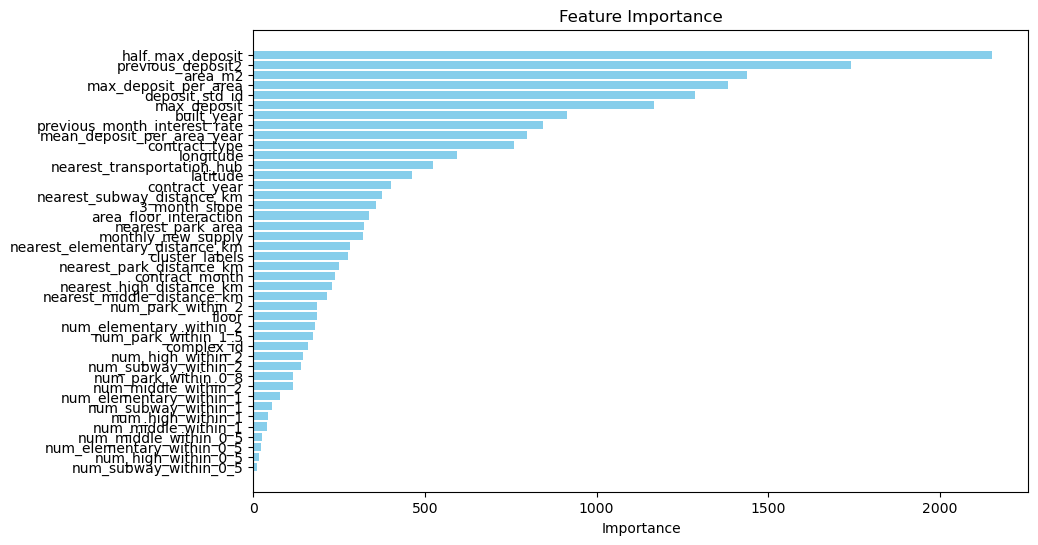

In [67]:
import matplotlib.pyplot as plt

importance = lgb_model1.feature_importances_
feature_names = X_train.columns  # 변수 이름

# 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()